In [ ]:
API_KEY = 'I5URZI94SKC6SHZW'

In [ ]:
import requests
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=IBM&outputsize=full&apikey={API_KEY}'
r = requests.get(url)
data = r.json()
df = pd.DataFrame.from_dict(data)

In [ ]:
meta_data_df = df[df['Time Series (Daily)'].isna()]
time_series_df = df[df['Time Series (Daily)'].notna()]
flattened_data = pd.json_normalize(time_series_df['Time Series (Daily)'])
flattened_data['Date'] = time_series_df.index

In [ ]:
all_except_date = flattened_data.drop(columns=['Date'])
as_array = all_except_date.values
date_column = flattened_data['Date']
as_array = as_array[::-1].astype(np.float64)
len(as_array)

5996

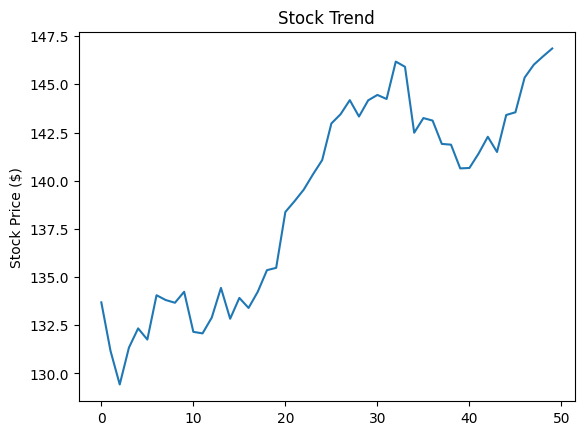

In [ ]:
def plot_stock_trend(var, cur_title, stockprices=flattened_data):
    plt.plot(list(map(lambda x: float(x), flattened_data.iloc[::-1][['4. close'][0]][-50:])))
    plt.figsize=(20, 10)
    plt.grid(False)
    plt.title(cur_title)
    plt.axis("tight")
    plt.ylabel("Stock Price ($)")

plot_stock_trend(var=50, cur_title="Stock Trend")

In [ ]:
N = 5000
input_seq_len = 50
output_seq_len = 1
train_ratio = 0.8
hidden_size = 50
num_layers = 2
batch_size = 20
epochs = 15
lr = 0.01

In [ ]:
train_size = int(N * train_ratio)
test_size = N - train_size
train_data, test_data = as_array[:train_size], as_array[train_size:train_size + test_size]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(as_array)
scaled_data_train = scaled_data[: train_data.shape[0]]

In [ ]:
def extract_seqX_outcomeY(data, N, offset):
    """
    Split time-series into training sequence X and outcome value Y
    Args:
        data - dataset
        N - window size, e.g., 50 for 50 days of historical stock prices
        offset - position to start the split
    """
    X, y = [], []

    for i in range(offset, len(data)):
        X.append(data[i - N : i])
        y.append(data[i])

    return np.array(X), np.array(y)

x_train, y_train = extract_seqX_outcomeY(scaled_data_train, 50, 50)
x_train_tensor = torch.FloatTensor(x_train)
y_train_tensor = torch.FloatTensor(y_train)
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=20, shuffle=False)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.linear(out[:, -output_seq_len, :])
        return out

In [ ]:
model = LSTM(5, hidden_size, 5, num_layers)
model = model
criterion = nn.MSELoss()
criterion = criterion
optimizer = optim.Adam(model.parameters())

In [ ]:
for epoch in range(epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        outputs = model(batch_x)
        optimizer.zero_grad()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/15], Loss: 0.2992
Epoch [2/15], Loss: 0.3621
Epoch [3/15], Loss: 0.3628
Epoch [4/15], Loss: 0.4175
Epoch [5/15], Loss: 0.3768
Epoch [6/15], Loss: 0.4316
Epoch [7/15], Loss: 0.2710
Epoch [8/15], Loss: 0.3648
Epoch [9/15], Loss: 0.1660
Epoch [10/15], Loss: 0.2823
Epoch [11/15], Loss: 0.1376
Epoch [12/15], Loss: 0.2078
Epoch [13/15], Loss: 0.1708
Epoch [14/15], Loss: 0.1225
Epoch [15/15], Loss: 0.1132


In [ ]:
data_df = pd.DataFrame(as_array, columns=["Open", "High", "Low", "Close", "Volume"])

In [ ]:
model.eval()
# predict stock prices using past window_size stock prices
def preprocess_testdat(data=data_df, scaler=scaler, window_size=50, test=test_data):
    raw = data[len(data) - len(test) - window_size:].values
    raw = scaler.transform(raw)

    X_test = [raw[i-window_size:i, :] for i in range(window_size, raw.shape[0])]
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))
    return X_test

X_test = preprocess_testdat()
X_test_tensor = torch.FloatTensor(X_test)
model = model
with torch.no_grad():
  predicted_price_ = model(X_test_tensor)
#predicted_price = scaler.inverse_transform(predicted_price_[:, -1, :])
predicted_price = scaler.inverse_transform(predicted_price_)

# Plot predicted price vs actual closing price
test_data_df = pd.DataFrame(test_data, columns=["Open", "High", "Low", "Close", "Volume"])  # Replace col1, col2, etc. with your actual column names
predicted_df = pd.DataFrame(predicted_price, columns=["Predicted_Open", "Predicted_High", "Predicted_Low", "Predicted_Close", "Predicted_Volume"])
test_data_df = pd.concat([test_data_df.reset_index(drop=True), predicted_df.reset_index(drop=True)], axis=1)

In [ ]:
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)
    """
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse


def calculate_mape(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [ ]:
train_data_df = pd.DataFrame(train_data, columns=["Open", "High", "Low", "Close", "Volume"])  # Replace col1, col2, etc. with your actual column names

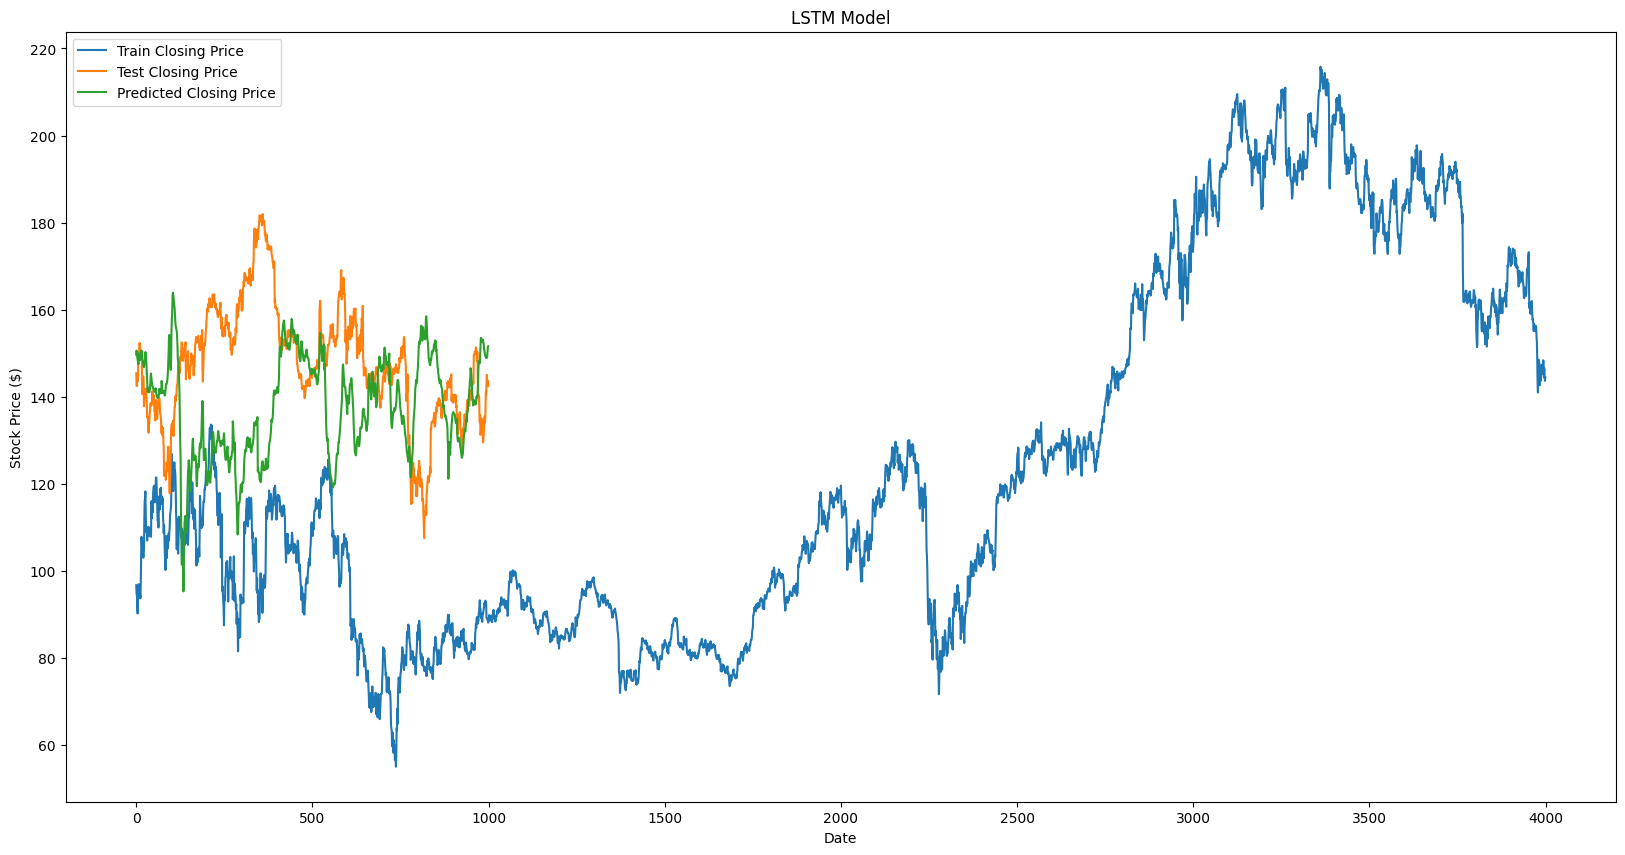

In [ ]:
rmse_lstm = calculate_rmse(np.array(test_data_df["Close"]), np.array(test_data_df["Predicted_Close"]))
mape_lstm = calculate_mape(np.array(test_data_df["Close"]), np.array(test_data_df["Predicted_Close"]))

def plot_stock_trend_lstm(train=train_data_df, test=test_data_df):
    fig = plt.figure(figsize = (20,10))
    plt.plot(np.asarray(train.index), np.asarray(train["Close"]), label = "Train Closing Price")
    plt.plot(np.asarray(test.index), np.asarray(test["Close"]), label = "Test Closing Price")
    plt.plot(np.asarray(test.index), np.asarray(test["Predicted_Close"]), label = "Predicted Closing Price")
    plt.title("LSTM Model")
    plt.xlabel("Date")
    plt.ylabel("Stock Price ($)")
    plt.legend(loc="upper left")

plot_stock_trend_lstm()

In [ ]:
print(test_data_df["Close"][-1:])
print(test_data_df["Predicted_Close"][-1:])

999    142.48
Name: Close, dtype: float64
999    151.635504
Name: Predicted_Close, dtype: float64


In [ ]:
test_data_df["Predicted_Close"]

0      149.683922
1      150.616756
2      149.891230
3      149.272738
4      148.365178
          ...    
995    148.990152
996    149.323956
997    150.348551
998    151.379065
999    151.635504
Name: Predicted_Close, Length: 1000, dtype: float64

In [ ]:
rmse_lstm

23.453183314579533

In [ ]:
mape_lstm

11.927221859992478

In [ ]:
most_recent = as_array[-50:]
most_recent = scaler.transform(most_recent)
most_recent_tensor = torch.FloatTensor(most_recent).unsqueeze(0)
with torch.no_grad():
  predicted = model(most_recent_tensor)
#predicted = scaler.inverse_transform(predicted_price_[:, -1, :])
predicted = scaler.inverse_transform(predicted)

In [ ]:
predicted[0, 3]

151.40666388450876

In [ ]:
df

,Meta Data,Time Series (Daily)
1. Information,"Daily Prices (open, high, low, close) and Volumes",NaN
2. Symbol,IBM,NaN
3. Last Refreshed,2023-08-30,NaN
4. Output Size,Full size,NaN
5. Time Zone,US/Eastern,NaN
...,...,...
1999-11-05,NaN,"{'1. open': '92.7500', '2. high': '92.9400', '..."
1999-11-04,NaN,"{'1. open': '94.4400', '2. high': '94.4400', '..."
1999-11-03,NaN,"{'1. open': '95.8700', '2. high': '95.9400', '..."
1999-11-02,NaN,"{'1. open': '96.7500', '2. high': '96.8100', '..."
